# Import libraries

In [1]:
import os
import sys
import numpy as np
import pandas as pd



repo_path = os.path.dirname(os.path.abspath(""))
CHECKOUT_PATH = repo_path
DATASET_PATH = os.path.join(repo_path, "datasets")

os.chdir(CHECKOUT_PATH)
sys.path.insert(0, CHECKOUT_PATH)

In [2]:
from alinemol.preprocessing import standardize_smiles, drop_duplicates
from alinemol.utils.split_utils import get_scaffold

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import rdFMCS
Draw.SetComicMode(IPythonConsole.drawOptions)

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm


In [20]:
#light_color = plt.get_cmap("plasma").colors[170]
#dark_color = plt.get_cmap("plasma").colors[5]
#dark_color = "black"


#matplotlib.use("pgf")


matplotlib.rcParams.update(
    {
        "pgf.texsystem": "pdflatex",
        "font.family": "serif",
        "font.serif": "Computer Modern Roman",
        "font.size": 14,
        "text.usetex": True,
        "pgf.rcfonts": False,
        "legend.loc": "upper right",
    }
)

sns.set_palette("Set2")

# Standardize the dataset

In [ ]:
mol_file = os.path.join(DATASET_PATH, "CHEMBL", "CHEMBL1614280", "CHEMBL1614280_simplified.csv")
mol_df = pd.read_csv(mol_file)
print(mol_df.shape)

In [ ]:
mol_df = standardize_smiles(mol_df)
print(mol_df.shape)

In [ ]:
mol_df = drop_duplicates(mol_df)
print(mol_df.shape)

In [7]:
df = mol_df[["canonical_smiles", "label"]]
df.columns = ["smiles", "label"]

df.to_csv(os.path.join(DATASET_PATH, "CHEMBL", "CHEMBL1614280", "CHEMBL1614280_standardize.csv"), index=False)

In [ ]:
mol_df[mol_df['canonical_smiles'].duplicated()]

In [6]:
X = np.array(mol_df["smiles"])
y = np.array(mol_df["label"])

In [12]:
scaf = [get_scaffold(smi) for smi in X]

In [ ]:
## chosse 6 random structure and corresponding scaffold
np.random.seed(7)
idx = np.random.choice(len(X), 6)
mols = [Chem.MolFromSmiles(X[i]) for i in idx]
scafs = [Chem.MolFromSmiles(scaf[i]) for i in idx]

## draw the molecules and their scaffolds
img = Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(300, 200), legends=[f"idx: {i}" for i in idx])
img

In [ ]:
# Draw scaffold
img_scaf = Draw.MolsToGridImage(scafs, molsPerRow=3, subImgSize=(300, 200), legends=[f"idx: {i}" for i in idx])
img_scaf

In [6]:
dataset_category="MoleculeNet"
dataset_names="HIV"
dataset = pd.read_csv(os.path.join(DATASET_PATH, dataset_category, dataset_names, "HIV_simplified" + ".csv"))

In [ ]:
dataset

In [ ]:
dataset['smiles'].duplicated().sum()

In [ ]:
new_df = standardize_smiles(dataset)

In [ ]:
new_df

In [ ]:
new_df['canonical_smiles'].isna().sum()

In [12]:
new_df = new_df.dropna(subset=['canonical_smiles'])
new_df = new_df[["canonical_smiles", "label"]]
new_df.columns = ["smiles", "label"]

In [14]:
new_df.to_csv(os.path.join(DATASET_PATH, dataset_category, dataset_names, "HIV_processed" + ".csv"), index=False)

In [ ]:
new_df[new_df['smiles'].duplicated()]

In [32]:
dff = new_df[new_df.groupby('smiles').label.transform('nunique') == 1]

In [40]:
dff=dff.drop_duplicates(subset=['smiles'], keep='first')

In [42]:
dff.reset_index(drop=True, inplace=True)

In [ ]:
dff.label.value_counts()

In [ ]:
new_df.groupby('smiles').label.nunique()>1

In [ ]:
new_df.groupby('smiles').label.transform('nunique')

In [3]:
x  = ['CC', 'CC', 'CC', 'CCC', 'CCC', 'CCCC', 'CCCCC', 'CCCCC']
label= [1, 1, 0, 1, 1, 1, 1, 0]
df = pd.DataFrame({'smiles': x, 'label': label})
df = standardize_smiles(df)

In [ ]:
df = df[['canonical_smiles', 'label']].rename(columns={'canonical_smiles': 'smiles'})

In [ ]:
drop_duplicates(df)['label'].nunique()

In [7]:
mol_df = mol_df[['canonical_smiles', 'label']].rename(columns={'canonical_smiles': 'smiles'})

In [8]:
import splito
from splito import *

In [14]:
def splits_scaffold(test_dataset_dili, make_generic):
    smiles = test_dataset_dili["smiles"].values
    splitter = ScaffoldSplit(smiles, n_splits=5, make_generic=make_generic, test_size=None)
    for train_ind, test_ind in splitter.split(smiles):
        assert len(train_ind) + len(test_ind) == len(smiles)
        assert len(set(train_ind).intersection(set(test_ind))) == 0
        assert len(train_ind) > 0 and len(test_ind) > 0
        print(len(train_ind))
        print(len(test_ind))

        train_scfs = set([get_scaffold(smiles[i], make_generic=make_generic) for i in train_ind])
        print(len(train_scfs))
        test_scfs = [get_scaffold(smiles[i], make_generic=make_generic) for i in test_ind]
        print(len(test_scfs))
        print(len(set(test_scfs)))
        print(test_scfs[0])
        assert not any(test_scf in train_scfs for test_scf in test_scfs)

In [ ]:
splits_scaffold(mol_df, make_generic=False)

In [63]:
import datamol as dm

In [76]:
def splits_molecular_weight(test_dataset_dili, generalize_to_larger):
    smiles = test_dataset_dili["smiles"].values
    splitter = MolecularWeightSplit(generalize_to_larger=generalize_to_larger, n_splits=2, test_size=0.1)

    for train_ind, test_ind in splitter.split(smiles):
        assert len(train_ind) + len(test_ind) == len(smiles)
        assert len(set(train_ind).intersection(set(test_ind))) == 0
        assert len(train_ind) > len(test_ind)
        assert len(train_ind) > 0 and len(test_ind) > 0
        print(len(train_ind))
        print(len(test_ind))

        train_mws = [dm.descriptors.mw(dm.to_mol(smi)) for smi in smiles[train_ind]]
        if generalize_to_larger:
            assert all(
                dm.descriptors.mw(dm.to_mol(smi)) >= max(train_mws) for smi in smiles[test_ind]
            )
        else:
            assert all(
                dm.descriptors.mw(dm.to_mol(smi)) <= min(train_mws) for smi in smiles[test_ind]
            )

In [82]:
from splito import MaxDissimilaritySplit

In [9]:
def test_splits_max_dissimilar_default_feats(test_dataset_smiles):
    splitter = MaxDissimilaritySplit(n_splits=2)

    for train_ind, test_ind in splitter.split(test_dataset_smiles):
        assert len(train_ind) + len(test_ind) == len(test_dataset_smiles)
        assert len(set(train_ind).intersection(set(test_ind))) == 0
        assert len(train_ind) > 0 and len(test_ind) > 0

In [ ]:
mol_df

In [11]:
smiles = mol_df["smiles"].values

In [ ]:
test_splits_max_dissimilar_default_feats(smiles)

In [87]:
from splito import PerimeterSplit


def test_splits_perimeter(test_dataset_smiles):
    splitter = PerimeterSplit(n_splits=2)

    for train_ind, test_ind in splitter.split(test_dataset_smiles):
        assert len(train_ind) + len(test_ind) == len(test_dataset_smiles)
        assert len(set(train_ind).intersection(set(test_ind))) == 0
        assert len(train_ind) > 0 and len(test_ind) > 0
        assert splitter._metric == "jaccard"

In [90]:
splitter = PerimeterSplit(n_splits=2)

In [ ]:
splitter

In [ ]:
splitter = PerimeterSplit(n_splits=2)

for train_ind, test_ind in splitter.split(smiles):
    assert len(train_ind) + len(test_ind) == len(smiles)
    assert len(set(train_ind).intersection(set(test_ind))) == 0
    assert len(train_ind) > 0 and len(test_ind) > 0
    assert splitter._metric == "jaccard"

In [ ]:
splits_molecular_weight(mol_df, generalize_to_larger=True)

In [ ]:
## aplly all the splitter that are available in splito on the moldf dataset and create train and test index
splitter = splito.MolecularWeightSplit(test_size=0.2, generalize_to_larger=True)
train_idx, test_idx = next(splitter.split(X=mol_df.smiles.tolist()))
assert train_idx.shape[0] > test_idx.shape[0]

In [22]:
mol_df.loc[train_idx, "MolecularWeightSplit"] = "train"
mol_df.loc[test_idx, "MolecularWeightSplit"] = "test"

In [23]:
import datamol as dm

In [24]:
mol_df["mw"] = mol_df.smiles.apply(lambda smi: dm.descriptors.mw(dm.to_mol(smi)))

In [ ]:
mol_df.groupby(by="MolecularWeightSplit")["mw"].hist(legend=True)

In [42]:
mol_df =mol_df[-mol_df.duplicated()]

In [ ]:
from alinemol.utils.split_utils import get_scaffold
for idx in mol_df.index:
    mol_df.loc[idx, "scaffold"] = get_scaffold(mol_df.loc[idx, "smiles"])

In [ ]:
for idx in mol_df.index:
    mol_df.loc[idx, "scaffold_generic"] = get_scaffold(mol_df.loc[idx, "smiles"], make_generic=True)

In [ ]:
mol_df['scaffold_generic'].nunique()

In [83]:
dataset_category="MoleculeNet"
dataset_names="HIV"
split_type="scaffold"
filename="external_test_balanced.csv"
train_filename="train_balanced.csv"
SPLIT_PATH = os.path.join(DATASET_PATH, dataset_category, dataset_names, "split")

In [84]:
external_test = pd.read_csv(os.path.join (SPLIT_PATH, split_type, filename))
train = pd.read_csv(os.path.join (SPLIT_PATH, split_type, train_filename))
df = pd.concat([external_test, train])

In [78]:
#df= pd.read_csv("datasets/TDC/CYP3A4/CYP3A4_simplified.csv")

In [85]:
train_scaf = [get_scaffold(smi) for smi in train["smiles"]]
external_test_scaf = [get_scaffold(smi) for smi in external_test["smiles"]]
df_scaf = [get_scaffold(smi) for smi in df["smiles"]]


In [ ]:
pd.Series(df_scaf).value_counts(sort=False).plot(kind='bar')

In [ ]:
fis, ax=plt.subplots(1, 3, figsize=(15, 5))
pd.Series(train_scaf).value_counts(sort=False).plot(kind='bar', ax=ax[0])

In [86]:
df_scaf_uni = list(set(df_scaf))

In [ ]:
#plot hist of df_scaf
from collections import Counter
#a=Counter(df_scaf)
#print(a)
import matplotlib.pyplot as plt
plt.hist(np.array(df_scaf), bins=10)
#plt.show()

In [ ]:
print(len(df_scaf_uni))
print(df.shape)
print(len(df_scaf_uni)/df.shape[0])

In [ ]:
train_scaf_uni = list(set(train_scaf))
external_test_scaf_uni = list(set(external_test_scaf))

print(len(train_scaf_uni))
print(len(train_scaf_uni)/train.shape[0])
print(len(external_test_scaf_uni))
print(len(external_test_scaf_uni)/external_test.shape[0])

print(set(train_scaf_uni).intersection(set(external_test_scaf_uni)))

## Dataset (train/test) charactersitics

In [ ]:
import json
import seaborn as sns
dataset_category="TDC"
dataset_names="HERG"
split_type="scaffold"

active_train= []
active_test = []
dataset_folder = os.path.join(DATASET_PATH, dataset_category, dataset_names, "split", split_type)

with open(os.path.join(dataset_folder, "config.json"), "r") as f:
    data_config = json.load(f)

for i in range(10):
    active_train.append(data_config[f"train_actives_percentage_{i}"])
    active_test.append(data_config[f"test_actives_percentage_{i}"])

#create df for sns plot
df = pd.DataFrame()
df['split'] = ['train'] *10 + ['test'] *10
df['active'] = active_train + active_test
df['id'] = list(range(10)) * 2

#plot active train vs active test as a bar plot in the same figure
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x='id', y='active', data=df, ax=ax, hue='split')
ax.set_ylabel("Active percentage", fontsize=16)
ax.set_xlabel("Split", fontsize=16)
ax.set_title(f"Active percentage in train and test {split_type} splits", fontsize=18)
ax.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [ ]:
df

# Plot performance of ID vs OOD

In [8]:
from alinemol.utils.utils import compute_ID_OOD
split_type="perimeter"
dataset_name="CYP2D6_TE02"
df = compute_ID_OOD(dataset_category="TDC", dataset_names=dataset_name, split_type=split_type, num_of_splits=10)
df.to_csv(os.path.join("classification_results", "TDC", dataset_name, split_type, "results.csv"), index=False)

(1517, 2)
(1517, 2)
(1517, 2)
(1517, 2)
(1517, 2)
(1517, 2)
(1517, 2)
(1517, 2)
(1517, 2)
(1517, 2)
(1517, 2)
(1517, 2)
(1517, 2)
(1517, 2)
(1968, 2)
(1968, 2)
(1968, 2)
(1968, 2)
(1968, 2)
(1968, 2)
(1968, 2)
(1968, 2)
(1968, 2)
(1968, 2)
(1968, 2)
(1968, 2)
(1968, 2)
(1968, 2)
(1519, 2)
(1519, 2)
(1519, 2)
(1519, 2)
(1519, 2)
(1519, 2)
(1519, 2)
(1519, 2)
(1519, 2)
(1519, 2)
(1519, 2)
(1519, 2)
(1519, 2)
(1519, 2)
(1698, 2)
(1698, 2)
(1698, 2)
(1698, 2)
(1698, 2)
(1698, 2)
(1698, 2)
(1698, 2)
(1698, 2)
(1698, 2)
(1698, 2)
(1698, 2)
(1698, 2)
(1698, 2)
(1542, 2)
(1542, 2)
(1542, 2)
(1542, 2)
(1542, 2)
(1542, 2)
(1542, 2)
(1542, 2)
(1542, 2)
(1542, 2)
(1542, 2)
(1542, 2)
(1542, 2)
(1542, 2)
(1778, 2)
(1778, 2)
(1778, 2)
(1778, 2)
(1778, 2)
(1778, 2)
(1778, 2)
(1778, 2)
(1778, 2)
(1778, 2)
(1778, 2)
(1778, 2)
(1778, 2)
(1778, 2)
(1989, 2)
(1989, 2)
(1989, 2)
(1989, 2)
(1989, 2)
(1989, 2)
(1989, 2)
(1989, 2)
(1989, 2)
(1989, 2)
(1989, 2)
(1989, 2)
(1989, 2)
(1989, 2)
(1951, 2)
(1951, 2)


In [9]:
split_type="scaffold"
results = pd.read_csv(os.path.join("classification_results", "TDC", "CYP2D6_TE02", split_type, "results.csv"))

In [10]:
results.shape

(130, 10)

In [11]:
#results = results.drop([80, 81, 82, 83, 84, 85, 86, 87, 88, 89])

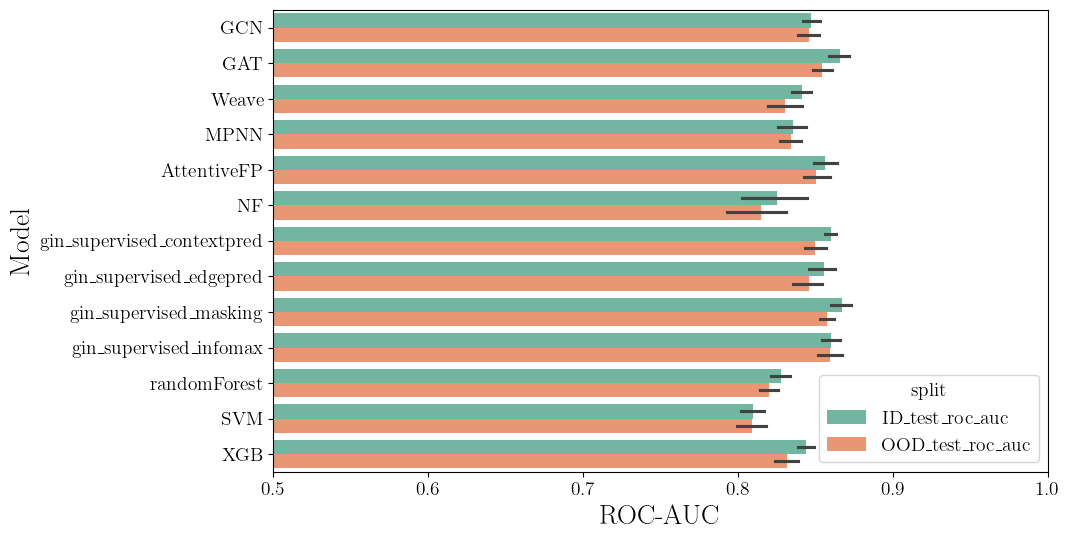

In [18]:
# barplot of the results (ID columns vs OOD Columns) for each model) in seaborn
# change sns font and font size
#sns.set_theme(style="whitegrid", rc={"text.usetex": True, "pgf.rcfonts": False, "font.serif": "Computer Modern Roman", "font.family": "serif"})
sns.set_palette("Set2")

tidy_1 = results.melt(id_vars=["model"], value_vars=["ID_test_accuracy", "OOD_test_accuracy"], var_name="split", value_name="accuracy")
tidy_2 = results.melt(id_vars=["model"], value_vars=["ID_test_roc_auc", "OOD_test_roc_auc"], var_name="split", value_name="roc_auc")
tidy3 = results.melt(id_vars=["model"], value_vars=["ID_test_pr_auc", "OOD_test_pr_auc"], var_name="split", value_name="pr_auc")


fig, ax = plt.subplots(figsize=(10, 6), nrows=1, ncols=1)

sns.barplot(y="model", x="roc_auc", hue="split", data=tidy_2, ax=ax, orient="h")
#sns.barplot(x="model", y="roc_auc", hue="split", data=tidy_2, ax=ax[1])
#sns.barplot(x="model", y="pr_auc", hue="split", data=tidy3, ax=ax[2])
ax.grid(False, axis='y')
ax.set_xlabel("ROC-AUC", fontsize=20)
ax.set_ylabel("Model", fontsize=20)
ax.set_xlim(0.5, 1.0)
plt.show()


In [13]:
results.groupby('model')

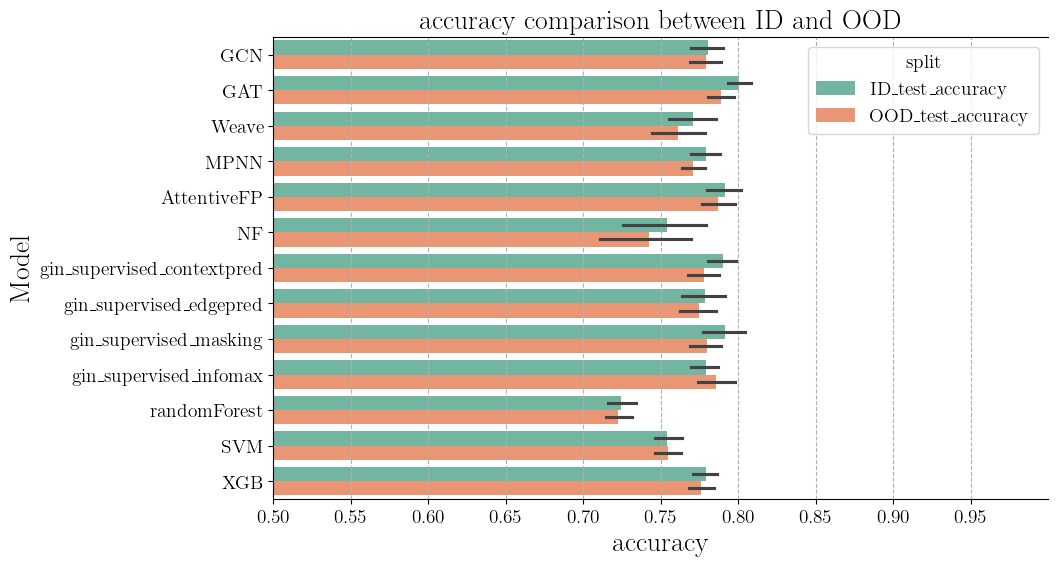

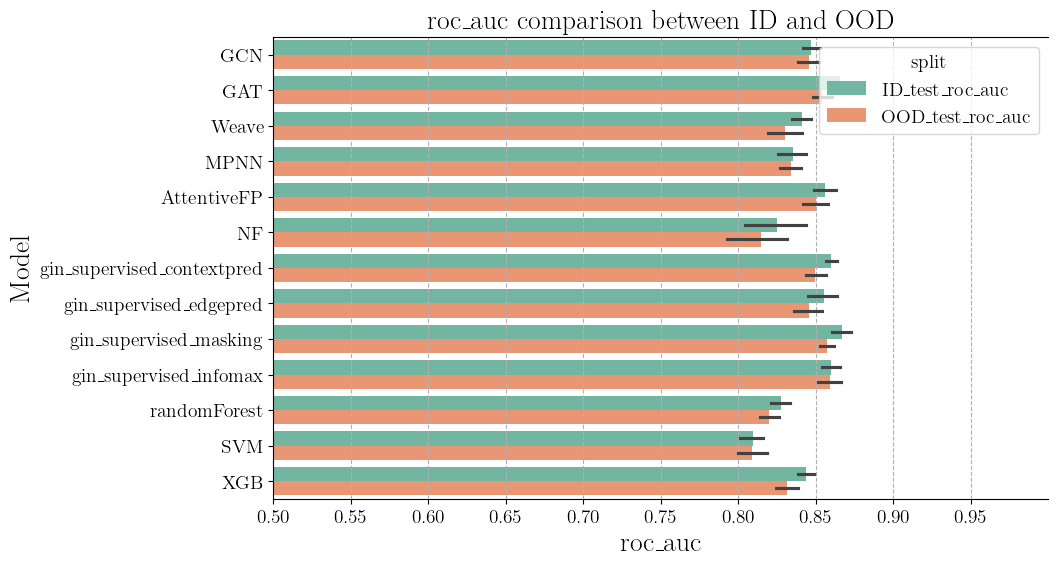

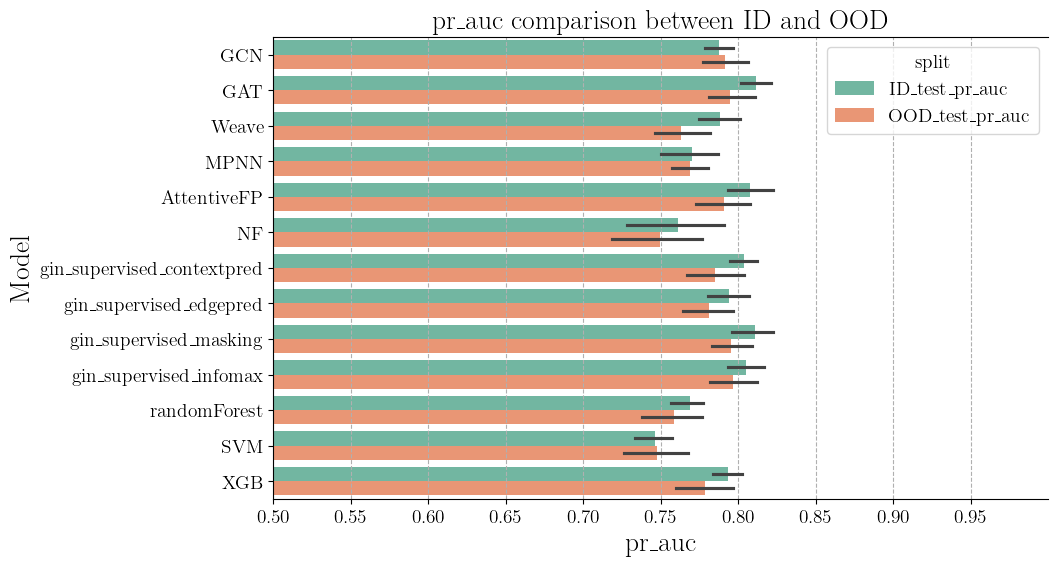

In [21]:
metrics = ['accuracy', 'roc_auc', 'pr_auc']
for metric in metrics:
    tidy = results.melt(id_vars=["model"], value_vars=[f"ID_test_{metric}", f"OOD_test_{metric}"], var_name="split", value_name=metric)
    fig, ax = plt.subplots(figsize=(10, 6), nrows=1, ncols=1)
    sns.barplot(y="model", x=metric, hue="split", data=tidy, ax=ax, orient="h")
    ax.grid(True, axis='x', linestyle='--')
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(metric, fontsize=20)
    ax.set_ylabel("Model", fontsize=20)
    ax.set_xlim(0.5, 1.0)
    ax.set_xticks(np.arange(0.5, 1.0, 0.05))
    ax.set_title(f"{metric} comparison between ID and OOD", fontsize=20)
    plt.show()

In [22]:
metrics = ['accuracy', 'roc_auc', 'pr_auc']
diff = []
for metric in metrics:
    results[f'diff_{metric}'] = results[f'ID_test_{metric}'] - results[f'OOD_test_{metric}']
    diff.append(results.groupby('model')[f'diff_{metric}'].mean())

In [23]:
diff = pd.concat(diff, axis=1)

In [24]:
diff

,diff_accuracy,diff_roc_auc,diff_pr_auc
model,,,
AttentiveFP,0.004509,0.005891,0.017034
GAT,0.011906,0.011150,0.016804
GCN,0.001298,0.001291,-0.004057
MPNN,0.008207,0.001413,0.001418
NF,0.011353,0.010545,0.011500
SVM,-0.000492,0.000351,-0.001240
Weave,0.009944,0.010554,0.025287
XGB,0.003204,0.012430,0.014779
gin_supervised_contextpred,0.012257,0.010131,0.019004


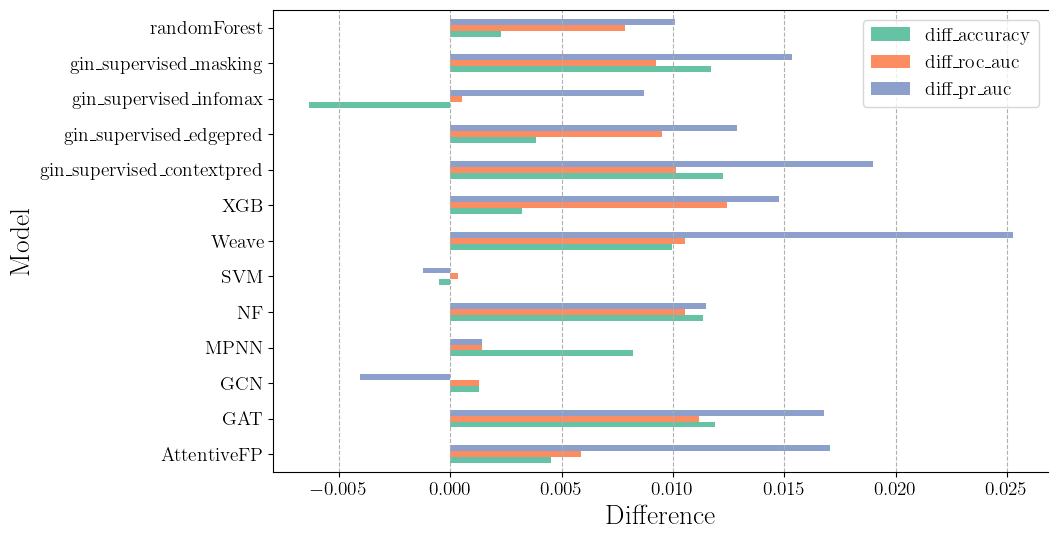

In [25]:
fig, ax = plt.subplots(figsize=(10, 6), nrows=1, ncols=1)
diff.plot(kind='barh', ax=ax)
ax.set_xlabel("Difference", fontsize=20)
ax.set_ylabel("Model", fontsize=20)
ax.grid(True, axis='x', linestyle='--')
ax.spines['right'].set_visible(False)
plt.show()

In [26]:
ML_MODELS = ['randomForest', 'SVM', 'XGB']
GNN_MODELS = ["GCN",
        "GAT",
        "Weave",
        "MPNN",
        "AttentiveFP",
        "NF",]

PRETRAINED_GNN_MODELS = ["gin_supervised_contextpred", "gin_supervised_edgepred", "gin_supervised_masking", "gin_supervised_infomax"]
ALL_MODELS = [ML_MODELS,  GNN_MODELS, PRETRAINED_GNN_MODELS]

In [27]:
# I want to have diff for ML_MODELS, GNN_MODELS, PRETRAINED_GNN_MODELS separately, and then plot them together
split_type="scaffold"
dataset_name="CYP2D6_TE02"
diff = []
for models in ALL_MODELS:
    results = pd.read_csv(os.path.join("classification_results", "TDC", dataset_name, split_type, "results.csv"))
    results = results[results['model'].isin(models)]
    metrics = ['accuracy', 'roc_auc', 'pr_auc']
    diff_models = []
    for metric in metrics:
        results[f'diff_{metric}'] = results[f'ID_test_{metric}'] - results[f'OOD_test_{metric}']
        diff_models.append(results.groupby('model')[f'diff_{metric}'].mean())
    diff_models = pd.concat(diff_models, axis=1)
    diff.append(diff_models)

In [28]:
diff[0]

,diff_accuracy,diff_roc_auc,diff_pr_auc
model,,,
SVM,-0.000492,0.000351,-0.001240
XGB,0.003204,0.012430,0.014779
randomForest,0.002270,0.007856,0.010072


In [29]:
diff[0].mean(axis=0) # ML_MODELS
diff[1].mean(axis=0) # GNN_MODELS
diff[2].mean(axis=0) # PRETRAINED_GNN_MODELS

#concat the diff[0], diff[1], and diff[2] and plot them


diff_accuracy    0.005369
diff_roc_auc     0.007345
diff_pr_auc      0.013989
dtype: float64

In [30]:
mean_df = pd.DataFrame([diff[0].mean(axis=0), diff[1].mean(axis=0), diff[2].mean(axis=0)], index=["ML_MODELS", "GNN_MODELS", "PRETRAINED_GNN_MODELS"])
mean_df

,diff_accuracy,diff_roc_auc,diff_pr_auc
ML_MODELS,0.001661,0.006879,0.007870
GNN_MODELS,0.007869,0.006807,0.011331
PRETRAINED_GNN_MODELS,0.005369,0.007345,0.013989


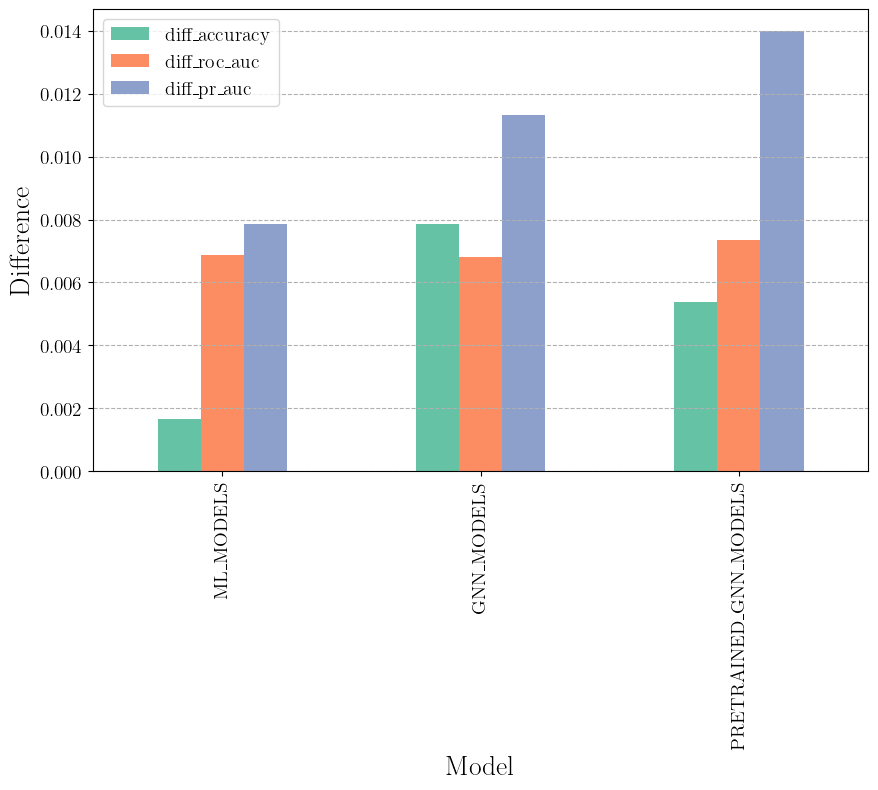

In [31]:
# plot the diff_roc_auc for ML_MODELS, GNN_MODELS, PRETRAINED_GNN_MODELS separately alongside each other
fig, ax = plt.subplots(figsize=(10, 6), nrows=1, ncols=1)
mean_df.plot(kind='bar', ax=ax)
ax.set_xlabel("Model", fontsize=20)
ax.set_ylabel("Difference", fontsize=20)
ax.grid(True, axis='y', linestyle='--')
plt.show()


In [ ]:
results.groupby('model')['ID_test_roc_auc'].mean() -  results.groupby('model')['OOD_test_roc_auc'].mean()

In [ ]:
results.groupby('model')['ID_test_pr_auc'].mean() -  results.groupby('model')['OOD_test_pr_auc'].mean()

In [ ]:
diff

In [ ]:
# grouped bar plot of ID_test_accuracy vs OOD_test_accuracy for each model in the results dataframe alongsilde each other
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
sns.set_theme(style="whitegrid", rc={"text.usetex": True, "pgf.rcfonts": False, "font.serif": "Computer Modern Roman", "font.family": "serif"})
results = results[['model', 'ID_test_accuracy', 'OOD_test_accuracy', 'ID_test_roc_auc', 'OOD_test_roc_auc', 'ID_test_pr_auc', 'OOD_test_pr_auc']]
results.groupby('model').mean().plot(kind='bar', y=['ID_test_accuracy', 'OOD_test_accuracy'], ax=ax, edgecolor='black', linewidth=1, fontsize=20)
ax.grid(False, axis='x')
ax.set_xlabel("Model", fontsize=24)
ax.set_ylabel("Accuracy", fontsize=24)
ax.set_ylim(0.5, 0.8)

In [ ]:
results

In [351]:
dataset_category="TDC"
dataset_names="CYP2C19"
split_types=["scaffold", "molecular_weight", "kmeans", "max_dissimilarity", "perimeter"]
models = ["GCN", "GAT", "Weave", "MPNN", "AttentiveFP", "NF", "gin_supervised_contextpred", "gin_supervised_edgepred", "gin_supervised_masking", "gin_supervised_infomax", "randomForest", "SVM", "XGB"]

## there is result.csv in each of the folder. I want to compine them and concatanate rows of the results
results = []
for split_type in split_types:
    results.append(pd.read_csv(os.path.join("classification_results", dataset_category, dataset_names, split_type, "results.csv")))
results = pd.concat(results)
results.to_csv(os.path.join("classification_results", dataset_category, dataset_names, "results.csv"), index=False)

In [394]:
dataset_category="TDC"
dataset_names="CYP3A4"
results = pd.read_csv(os.path.join("classification_results", dataset_category, dataset_names, "results.csv"))

In [395]:
# First gropuby by splits and then comute the mean and std of accuarcy, roc_auc and pr_auc colums
dff =results.groupby('split')[['ID_test_accuracy', 'OOD_test_accuracy', 'ID_test_roc_auc', 'OOD_test_roc_auc', 'ID_test_pr_auc', 'OOD_test_pr_auc']].agg(['mean', 'std'])

In [ ]:
dff

In [ ]:
results.groupby('split')[['ID_test_accuracy', 'OOD_test_accuracy', 'ID_test_roc_auc', 'OOD_test_roc_auc', 'ID_test_pr_auc', 'OOD_test_pr_auc']].mean()

In [ ]:
dff

In [ ]:
results.groupby('split')['test_size'].mean()

In [398]:
# combine results for all the datasets in the TDC folder
dataset_category="TDC"
datasets = os.listdir(os.path.join("classification_results", dataset_category))
results = []
for dataset in datasets:
    results.append(pd.read_csv(os.path.join("classification_results", dataset_category, dataset, "results.csv")))

results = pd.concat(results)

results.to_csv(os.path.join("classification_results", dataset_category, "results.csv"), index=False)


In [ ]:
results.groupby('dataset')['ID_test_roc_auc'].mean()

## Analysis of the performance of ID vs OOD

In [38]:
results = pd.read_csv(os.path.join("classification_results", "TDC", "results.csv"))

In [ ]:
## First, lets have a look on the absolute performance of in distribution on all the datasets
results.groupby('dataset')['ID_test_roc_auc'].mean().plot(kind='bar', figsize=(10, 6))
plt.ylabel("ROC-AUC", fontsize=20)
plt.show()

In [ ]:
## First, lets have a look on the absolute performance of in distribution on all the datasets
results.groupby('dataset')['ID_test_accuracy'].mean().plot(kind='bar', figsize=(10, 6))
plt.ylabel("ACC", fontsize=20)
plt.show()

In [ ]:
## First, lets have a look on the absolute performance of in distribution on all the datasets
results.groupby('dataset')['ID_test_pr_auc'].mean().plot(kind='bar', figsize=(10, 6))
plt.ylabel("PR-AUC", fontsize=20)
plt.show()

In [ ]:
## Then lets compare the performance drop for each dataset acroos each split
results.groupby('dataset')['ID_test_roc_auc'].mean() - results.groupby('dataset')['OOD_test_roc_auc'].mean()

In [420]:
a=results.groupby(['dataset', 'split'])['ID_test_roc_auc'].mean() - results.groupby(['dataset', 'split'])['OOD_test_roc_auc'].mean()

In [ ]:
# Just pick the scaffold split from all the spli in the dataframe
b=results[results['split']=='scaffold']
b.groupby('dataset')['ID_test_roc_auc'].mean() - b.groupby('dataset')['OOD_test_roc_auc'].mean()